In [177]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import pickle, random
from tqdm import tqdm
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

In [178]:
#!pip install tqdm

In [ ]:
#df0 = pd.read_csv('../spreadsheets/rlhf_20250104_6.csv') # 0.9, 0.95, 1.0, 0.99, 0.99, 8000
#df0 = pd.read_csv('../spreadsheets/rlhf_159nlp.csv') # Best 0.01, 0.85, 0.01, 0.95, 0.95, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_1064_2.csv') # 0.05, 0.99, 0.5, 0.99, 0.997, 6000, 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_1072.csv') # 0.05, 0.99, 0.5, 0.99, 0.997, 6000
#df0 = pd.read_csv('../spreadsheets/shufled_rlhf_11rl.csv') # 0.01, 0.95, 1.0, 0.997, 0.995, 26000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_12rl.csv') # 0.01, 0.85, 0.01, 0.95, 0.95, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_15rl.csv') # 0.05, 0.95, 1.0, 0.999, 0.995, 12000, 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_19rl.csv') # 0.01, 0.95, 1.0, 0.997, 0.995, 26000, 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_24rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_25rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_26rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_157nlp.csv') # 0.7, 0.95, 0.5, 0.999, 0.99, 16000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_157nlpgate.csv') # 0.25, 0.95, 0.01, 0.997, 0.999, 14000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_29rl.csv') # 0.9, 0.9, 0.005, 0.95, 0.999, 10000, 0.9, 0.95, 1.0, 0.99, 0.99, 8000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_30rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_32rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_33rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_35rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_36rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_37rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_38rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_39rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_39rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_40rl_refined.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_154nlp.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_159nlp.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_43rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_46rl.csv') # 0.001, 0.99, 1.0, 0.95, 0.99, 10000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_54rl.csv')
#df0 = pd.read_csv('/home/defi/Desktop/portfolio/projects/python/pipeline_defi/lean_df_50rl.csv')
df0 = pd.read_csv('../spreadsheets/rlhf_large_12rl_refineds.csv') #0.05, 0.95, 0.05, 0.99, 0.95, 8000

In [180]:
df0['ask'] = df0['close'] * df0['volume']/(df0['close'] + df0['open'])

In [181]:
df0['bid'] = df0['open'] * df0['volume']/(df0['close'] + df0['open'])

In [182]:
df0.head()

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-05,sma-07,...,long_jcrosk,short_kdj,sma-compare,ask,bid,is_short,nlpreds,predicted_action,reward,refined-action
0,7.7070,7.7330,8.848399,9.877985,6.3350,1,6.3710,240398.49,8.17960,8.497286,...,0,0,1,1.087924e+05,1.316061e+05,1,go_short,go_short,-15.420045,go_short
1,7.7070,7.7330,8.848399,9.877985,6.3350,1,6.3710,240398.49,8.17960,8.497286,...,0,0,1,1.087924e+05,1.316061e+05,1,go_short,go_short,-15.420045,go_short
2,0.1074,0.1157,0.128354,0.139058,0.1016,0,0.1147,17317281.30,0.12160,0.125000,...,0,0,1,8.943234e+06,8.374048e+06,1,go_long,go_long,-15.379725,go_long
3,19.4240,19.5530,19.686034,19.868286,19.2230,1,19.2750,469423.97,19.60600,19.661286,...,1,0,1,2.338083e+05,2.356157e+05,1,do_nothing,do_nothing,-14.164563,do_nothing
4,0.2986,0.3064,0.313629,0.316249,0.2980,1,0.3047,623564.50,0.31104,0.313414,...,0,0,1,3.149347e+05,3.086298e+05,1,go_long,go_long,8.686893,go_short


In [183]:
#df0['refined-action'].value_counts()

In [184]:
#df0.drop(['Unnamed:','predicted_action'], axis=1, inplace=True)

In [185]:
#df0['nlpreds'].value_counts()

In [186]:
#action_mapping = {"go_long": 0, "go_short": 1}

In [187]:
def prep_data(df: DataFrame) -> DataFrame:
    train_data = pd.DataFrame()
    for col in df.columns:
        col_name = col.split(' ')[0]
        train_data[f'{col_name}'] = df[col]

    return train_data

In [188]:
#newdf0 = pd.DataFrame()
train_data = prep_data(df0) if newdf0.empty else prep_data(newdf0)
#train_data = prep_data(newdf0)

In [189]:
train_data.head(2)

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-05,sma-07,...,short_kdj,sma-compare,ask,bid,is_short,nlpreds,predicted_action,reward,refined-action,action_num
0,7.707,7.733,8.848399,9.877985,6.335,1,6.371,240398.49,8.1796,8.497286,...,0,1,108792.355433,131606.134567,1,go_short,go_short,-15.420045,go_short,1
1,7.707,7.733,8.848399,9.877985,6.335,1,6.371,240398.49,8.1796,8.497286,...,0,1,108792.355433,131606.134567,1,go_short,go_short,-15.420045,go_short,1


In [190]:
new_cols = ['open', 'high', 'ema-26', 'ema-12', 'low', \
            'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk', 'short_kdj', \
            'sma-compare', 'ask', 'bid', 'is_short'
        ]

In [191]:
# Encode actions into numerical values
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
action_col = 'imit-action' if newdf0.empty else 'refined-action'
train_data["action_num"] = train_data[f"{action_col}"].map(action_mapping)

In [192]:
# Define RL parameters
#states = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values  # Include binary_state
states = train_data[new_cols].values
actions = list(action_mapping.values())  # Action space
rewards = train_data["reward"].values  # Rewards
n_states = states.shape[0]
n_actions = len(actions)

In [193]:
# Initialize Q-table
q_table = np.zeros((n_states, n_actions))

In [ ]:
# Hyperparameters [0.25, 0.95, 1.0, 0.99, 0.99, 10000], [0.9, 0.95, 1.0, 0.99, 0.99, 8000], [0.7, 0.75, 1.0, 0.97, 0.999, 28000]
# [0.05, 0.95, 1.0, 0.999, 0.995, 12000], [1, 0.95, 0.1, 0.96, 0.96, 12000], [0.25, 0.99, 0.01, 0.997, 0.99, 8000]
# [1, 0.75, 0.05, 0.999, 0.999, 10000], [0.01, 0.85, 0.01, 0.95, 0.95, 12000], [0.01, 0.99, 1.0, 0.95, 0.99, 16000], [0.05, 0.99, 0.5, 0.99, 0.997, 6000]
# [0.25, 0.95, 0.01, 0.997, 0.999, 14000], [0.01, 0.95, 1.0, 0.997, 0.995, 26000], [0.9, 0.9, 0.005, 0.95, 0.999, 10000]
# [0.7, 0.95, 0.5, 0.999, 0.99, 16000], [0.005, 0.75, 0.1, 0.95, 0.999, 12000], [0.001, 0.75, 1.0, 0.99, 0.99, 30000]
# [0.25, 0.75, 0.01, 0.995, 0.999, 20000], [0.001, 0.99, 1.0, 0.95, 0.99, 10000], [1, 0.75, 0.005, 0.95, 0.95, 22000]
'''
alpha = 1
gamma = 0.95
epsilon = 0.1
min_epsilon = 0.96
decay_rate = 0.96
n_episodes = 12000
'''
alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes = 0.001, 0.99, 1.0, 0.95, 0.99, 10000 #0.25, 0.75, 0.01, 0.995, 0.999, 20000 #0.9, 0.9, 0.005, 0.95, 0.999, 10000 # 0.25, 0.95, 0.01, 0.997, 0.999, 14000



In [195]:
def create_state_index_mapping(df):
    state_to_index = {}
    for idx, row in df.iterrows():
        state = (row['open'], row['high'], row['ema-26'], row['ema-12'], row['low'], \
                 row['mean-grad-hist'], row['close'], row['volume'], row['sma-25'], \
                 row['long_jcrosk'], row['short_kdj'], row['sma-compare'], row['ask'], \
                 row['bid'], row['is_short']
                )
        state_to_index[state] = idx
    return state_to_index

# Assuming 'df' is your dataframe used during training
state_to_index = create_state_index_mapping(train_data)

# Save the state_to_index dictionary for later use
np.save('large_state_to_index.npy', state_to_index)


In [196]:
# Helper function to choose an action using epsilon-greedy
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(q_table[state])  # Exploit: best known action

evaluating results per episode ...:   0%|          | 12/8000 [00:00<01:08, 116.05it/s]

Episode 0/8000 - Total Reward: -14530.72450483984, Epsilon: 0.99


evaluating results per episode ...:   5%|▌         | 417/8000 [00:03<01:03, 119.71it/s]

Episode 400/8000 - Total Reward: -514.1645703100002, Epsilon: 0.99


evaluating results per episode ...:  10%|█         | 820/8000 [00:06<01:03, 113.76it/s]

Episode 800/8000 - Total Reward: -16897.2277157998, Epsilon: 0.99


evaluating results per episode ...:  15%|█▌        | 1214/8000 [00:10<00:59, 114.03it/s]

Episode 1200/8000 - Total Reward: -1076.1637240599994, Epsilon: 0.99


evaluating results per episode ...:  20%|██        | 1619/8000 [00:13<00:59, 107.32it/s]

Episode 1600/8000 - Total Reward: -11763.803859969888, Epsilon: 0.99


evaluating results per episode ...:  25%|██▌       | 2025/8000 [00:17<00:52, 113.64it/s]

Episode 2000/8000 - Total Reward: -12624.708146599878, Epsilon: 0.99


evaluating results per episode ...:  30%|███       | 2418/8000 [00:20<00:52, 105.39it/s]

Episode 2400/8000 - Total Reward: -6761.073393749991, Epsilon: 0.99


evaluating results per episode ...:  35%|███▌      | 2811/8000 [00:24<00:41, 124.07it/s]

Episode 2800/8000 - Total Reward: -10233.054266529918, Epsilon: 0.99


evaluating results per episode ...:  40%|████      | 3222/8000 [00:27<00:39, 119.91it/s]

Episode 3200/8000 - Total Reward: -7549.926967619984, Epsilon: 0.99


evaluating results per episode ...:  45%|████▌     | 3620/8000 [00:31<00:37, 115.92it/s]

Episode 3600/8000 - Total Reward: -11837.909480639886, Epsilon: 0.99


evaluating results per episode ...:  50%|█████     | 4023/8000 [00:34<00:34, 115.59it/s]

Episode 4000/8000 - Total Reward: -17429.754663199823, Epsilon: 0.99


evaluating results per episode ...:  55%|█████▌    | 4416/8000 [00:37<00:27, 132.71it/s]

Episode 4400/8000 - Total Reward: -11962.080765909883, Epsilon: 0.99


evaluating results per episode ...:  60%|██████    | 4819/8000 [00:41<00:28, 110.09it/s]

Episode 4800/8000 - Total Reward: -8332.212421179978, Epsilon: 0.99


evaluating results per episode ...:  65%|██████▌   | 5217/8000 [00:44<00:22, 124.76it/s]

Episode 5200/8000 - Total Reward: -3263.123696490011, Epsilon: 0.99


evaluating results per episode ...:  70%|███████   | 5621/8000 [00:48<00:17, 134.51it/s]

Episode 5600/8000 - Total Reward: -16899.4493901498, Epsilon: 0.99


evaluating results per episode ...:  75%|███████▌  | 6018/8000 [00:51<00:19, 100.40it/s]

Episode 6000/8000 - Total Reward: -10422.161413709913, Epsilon: 0.99


evaluating results per episode ...:  80%|████████  | 6421/8000 [00:55<00:13, 115.65it/s]

Episode 6400/8000 - Total Reward: -67.75735261, Epsilon: 0.99


evaluating results per episode ...:  85%|████████▌ | 6825/8000 [00:58<00:09, 119.37it/s]

Episode 6800/8000 - Total Reward: -5670.047704940004, Epsilon: 0.99


evaluating results per episode ...:  90%|█████████ | 7214/8000 [01:02<00:07, 106.42it/s]

Episode 7200/8000 - Total Reward: -7582.0255373999835, Epsilon: 0.99


evaluating results per episode ...:  95%|█████████▌| 7619/8000 [01:05<00:03, 125.47it/s]

Episode 7600/8000 - Total Reward: -11395.56281098989, Epsilon: 0.99


evaluating results per episode ...: 100%|██████████| 8000/8000 [01:08<00:00, 116.51it/s]


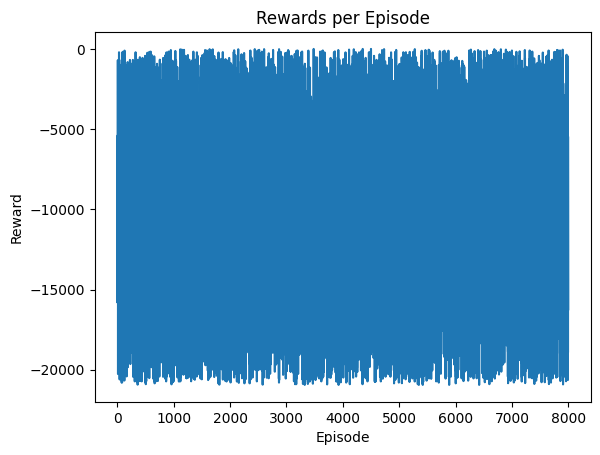

In [197]:

# Set random seed for reproducibility and train the loop
np.random.seed(42)
random.seed(42)
# Initialize a list to store rewards per episode
rewards_per_episode = []

for episode in tqdm(range(n_episodes), desc="evaluating results per episode ..."):
    current_state = np.random.randint(0, n_states)  # Random initial state
    total_reward = 0  # Initialize total reward for the current episode

    while current_state < n_states - 1:
        action = choose_action(current_state, epsilon)
        
        next_state = current_state + 1  # This depends on your environment logic
        reward = rewards[next_state]

        best_next_action = np.argmax(q_table[next_state])
        q_table[current_state, action] += alpha * (
            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
        )
        
        total_reward += reward  # Accumulate reward for the current episode
        current_state = next_state  # Move to next state

    rewards_per_episode.append(total_reward)  # Store the total reward for the current episode

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Optional: Log progress
    if episode % 400 == 0:  # Adjust logging frequency as needed
        print(f"Episode {episode}/{n_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")

# Example: Save the Q-table
np.save("large_q_table.npy", q_table)

# Example: Plotting the rewards
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()



In [198]:
def load_q_table(file_path):
    return np.load(file_path)

def load_state_index_mapping(file_path):
    return np.load(file_path, allow_pickle=True).item()

loaded_mapping = load_state_index_mapping(file_path="large_state_to_index.npy")
loaded_qtable = load_q_table(file_path="large_q_table.npy")

In [199]:
#state = (row['open'], row['high'], row['ema-26'], row['ema-12'], row['low'], \
#                 row['mean-grad-hist'], row['close'], row['volume'], row['sma-25'], \
#                 row['long_jcrosk'], row['short_kdj'], row['sma-compare'], row['is_short'])

def prep_state(
                open: float, high: float, ema_26: float, ema_12: float, low: float,
                mean_grad_hist: float, close: float, volume: float, sma_25: float,
                long_jcrosk: float, short_kdj: float, sma_compare: int, is_short: int,
            ):
    state = np.array([[open, high, ema_26, ema_12, low, mean_grad_hist, close, volume, sma_25, long_jcrosk, short_kdj, sma_compare, is_short]])
    if not np.all(np.isfinite(state)):
        state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
    return state


In [200]:

def predict_action(state, q_table, state_to_index, action_mapping, default_action: str = None):
    state_tuple = tuple(state.flatten())

    state_index = state_to_index.get(state_tuple, -1)

    if not state_index == -1:
        try:
            q_values = q_table[state_index]
        except ValueError as e:
            print(e)
            #return default_action
    else:
        state_tuples = list(state_to_index.keys())
        kdtree = KDTree(state_tuples)
        distance, index = kdtree.query(state.flatten())
        nearest_state_tuple = state_tuples[index]
        new_state_index = state_to_index[nearest_state_tuple]
        q_values = loaded_qtable[new_state_index]
    
    #q_values = q_table[state_index]
    best_action_index = np.argmax(q_values)
    action = [action for action, index in action_mapping.items() if index == best_action_index][0]
    return action

In [201]:
# Predict an entire range
for idx, row in train_data.iterrows():
    state = row[['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk', 'short_kdj', 'sma-compare', 'ask', 'bid', 'is_short']].values
    action = predict_action(state, q_table, state_to_index, action_mapping)
    train_data.loc[idx, "predicted_action"] = action

In [202]:
# Predict an entire range
def predict_range(filename: str) -> DataFrame:
    df = pd.read_csv(filename)
    df['action_num'] = train_data['action_num']
    for idx, row in df.iterrows():
        state = row[['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk', 'short_kdj', 'sma-compare', 'ask', 'bid', 'is_short']].values
        action = predict_action(state, q_table, state_to_index, action_mapping)
        df.loc[idx, "predicted_action"] = action
    return df

### Change this to predict a different file

In [203]:
#train_data = predict_range('../spreadsheets/rlhf_large_1072.csv')

In [204]:
train_data['predicted_action'].value_counts()

predicted_action
go_long       2130
do_nothing     440
go_short       334
Name: count, dtype: int64

In [205]:
m = train_data[((train_data['predicted_action'] == 'go_short') & (train_data['predicted_action'] == 'do_nothing')) & (train_data['reward'] > 0)]
m['is_short'].value_counts()

Series([], Name: count, dtype: int64)

In [206]:
longs = dict(m['is_short'].value_counts().items()).get(0)
print(longs)
shorts = dict(m['is_short'].value_counts().items()).get(1)
print(shorts)

None
None


In [207]:
# Performance measures
# Initialize cumulative rewards
cumulative_predicted_reward = 0
cumulative_actual_reward = 0

# Iterate through states to calculate rewards
for state_index in range(n_states - 1):
    # Predicted action from Q-table
    predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
    # Actual action from the ground truth
    actual_action = train_data["action_num"].iloc[state_index]

    # Get reward for predicted action only if it matches the actual action
    if predicted_action == actual_action:
        predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
        cumulative_predicted_reward += predicted_reward

    # Get actual reward for the ground truth action
    actual_reward = rewards[state_index + 1]
    cumulative_actual_reward += actual_reward

    # Optional: Log progress
    if state_index % 100 == 0:  # Adjust logging frequency as needed
        print(f"Processed state {state_index}/{n_states - 1}")
        print(f"Current Predicted Reward: {cumulative_predicted_reward}")
        print(f"Current Actual Reward: {cumulative_actual_reward}")

# Print results
print(f"Cumulative Predicted Reward: {cumulative_predicted_reward}")
print(f"Cumulative Actual Reward: {cumulative_actual_reward}")

# Optionally calculate efficiency
efficiency = (
    ((cumulative_predicted_reward - cumulative_actual_reward) / abs(cumulative_actual_reward)) * 100
    if cumulative_actual_reward != 0
    else 0
)
print(f"Prediction Efficiency: {efficiency:.2f}%")



Processed state 0/2903
Current Predicted Reward: 0
Current Actual Reward: -15.42004548
Processed state 100/2903
Current Predicted Reward: -241.55897703000002
Current Actual Reward: -576.3845261900003
Processed state 200/2903
Current Predicted Reward: -530.4157323300001
Current Actual Reward: -1398.076007439999
Processed state 300/2903
Current Predicted Reward: -715.3029985599999
Current Actual Reward: -2129.6495225200015
Processed state 400/2903
Current Predicted Reward: -1013.1783878399993
Current Actual Reward: -3055.631999710006
Processed state 500/2903
Current Predicted Reward: -1324.9464763899994
Current Actual Reward: -3926.0988491800135
Processed state 600/2903
Current Predicted Reward: -1557.3808595299997
Current Actual Reward: -4713.279262400009
Processed state 700/2903
Current Predicted Reward: -1830.33060797
Current Actual Reward: -5227.929001150005
Processed state 800/2903
Current Predicted Reward: -2049.32751916
Current Actual Reward: -5986.695442339997
Processed state 900

In [208]:
# Accuracy

correct_predictions = 0
for state_index in range(n_states):
    predicted_action = np.argmax(q_table[state_index])  # Predicted action
    actual_action = train_data["action_num"].iloc[state_index]  # Actual action
    if predicted_action == actual_action:
        correct_predictions += 1

accuracy = correct_predictions / n_states

print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 33.68%


In [209]:
# Confusion matrix
y_true = train_data["action_num"]  # Actual actions
y_pred = [np.argmax(q_table[state_index]) for state_index in range(n_states)]  # Predicted actions

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[338 280 342]
 [449 456 429]
 [206 220 184]]


In [210]:
def accuracy(conf_matrix, n_states):
    # True Positives (TP): Diagonal elements of the confusion matrix
    TP = conf_matrix[0][0] + conf_matrix[1][1] + conf_matrix[2][2]
    # **True Positives**: 16 (class 0), 0 (class 1), 0 (class 2)
    return TP/n_states

In [211]:
print(accuracy(cm, n_states=n_states))

0.3367768595041322


In [212]:
df0['nlpreds'].value_counts()

nlpreds
go_long       1217
do_nothing     919
go_short       768
Name: count, dtype: int64

In [213]:
def action_reward(action: str, is_short: int):
    m = train_data[(train_data['predicted_action'] == f'{action}') & (train_data['is_short'] == is_short)]
    counts = m['is_short'].value_counts()
    total_reward = m['reward'].cumsum()[-1:].values[0]
    wins = len(m[m['reward'] > 0])
    losses = len(m[m['reward'] <= 0])
    return {
        'counts': counts.get(is_short),
        'total reward': total_reward,
        'winrate': f'{wins * 100 / (losses + wins):.2f}%',
        'per trade profit': m[m['reward'] > 0]['reward'].sum() / wins,
        'per trade loss': m[m['reward'] <= 0]['reward'].sum() / losses
    }

In [214]:
action_reward('go_long', 0)

{'counts': 2,
 'total reward': -14.178134499999999,
 'winrate': '50.00%',
 'per trade profit': 1.19697552,
 'per trade loss': -15.37511002}

In [215]:
dirs = [0,1]
for action in action_mapping.keys():
    for is_short in dirs:
        try:
            print(f'{action} {is_short}: {action_reward(action, is_short)}')
        except IndexError as e:
            print(e)

go_long 0: {'counts': 2, 'total reward': -14.178134499999999, 'winrate': '50.00%', 'per trade profit': 1.19697552, 'per trade loss': -15.37511002}
go_long 1: {'counts': 2128, 'total reward': -21555.91659866997, 'winrate': '19.60%', 'per trade profit': 8.587176993045563, 'per trade loss': -14.691273760824078}
go_short 0: {'counts': 4, 'total reward': -13.42421237, 'winrate': '75.00%', 'per trade profit': 0.3975193666666667, 'per trade loss': -14.61677047}
go_short 1: {'counts': 330, 'total reward': -269.94192456000025, 'winrate': '46.06%', 'per trade profit': 7.410782947697368, 'per trade loss': -7.844836700056179}
do_nothing 0: {'counts': 2, 'total reward': 3.03491315, 'winrate': '100.00%', 'per trade profit': 1.517456575, 'per trade loss': nan}
do_nothing 1: {'counts': 438, 'total reward': 887.6501343100014, 'winrate': '59.82%', 'per trade profit': 8.42238565572519, 'per trade loss': -7.494402883465908}


/tmp/ipykernel_3045500/3005952004.py:12: RuntimeWarning: invalid value encountered in scalar divide
  'per trade loss': m[m['reward'] <= 0]['reward'].sum() / losses


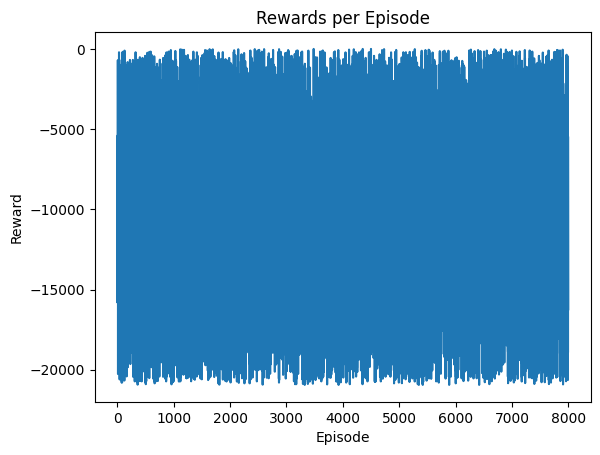

In [216]:
import matplotlib.pyplot as plt

# Assuming you have a list of rewards for each episode
#rewards_per_episode = [...]  # Populate this with your actual data

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


In [228]:
# create corrected action
def correct_action(row):
    if row['predicted_action'] == 'go_long' and row['is_short'] == 1 and row['reward'] > 0:
        return 'go_short'
    if row['predicted_action'] == 'go_short' and row['is_short'] == 0 and row['reward'] > 0:
        return 'go_long'
    if row['predicted_action'] == 'do_nothing' and row['is_short'] == 1 and row['reward'] > 0:
        return 'go_short'
    if row['predicted_action'] == 'do_nothing' and row['is_short'] == 0 and row['reward'] > 0:
        return 'go_long'
    return row['predicted_action']

def refiner_action(version: str, data: DataFrame = None) -> DataFrame:
    data['refined-action'] = data.apply(lambda x: correct_action(x), axis=1)
    # Validation: Ensure we're fixing the 751 misclassified entries
    misclassified = data[
        (data['predicted_action'] == 'go_long') & 
        (data['refined-action'] == 'go_short')
    ]
    # Add this after applying refined-action
    confusion_matrix = pd.crosstab(
        data['refined-action'], 
        data['predicted_action'],  # Assuming you have ground truth column
        rownames=['refined'],
        colnames=['predicted']
    )
    print("Updated Confusion Matrix:")
    print(confusion_matrix) 
    print(f"Corrected {len(misclassified)} go_long->go_short misclassifications")
    filename = f'../spreadsheets/rlhf_large_{version}_refined.csv'
    data.to_csv(filename, index=False)
    return data

In [229]:
base_dir = '/home/defi/Desktop/portfolio/projects/python/pipeline_defi/'

def refine_file(version: str, file) -> DataFrame:
    filename = f'{base_dir}{file}.csv'
    print(filename)
    df = pd.read_csv(filename)
    new_data = prep_data(df) if newdf0.empty else prep_data(newdf0.copy())
    #new_data = prep_data(df)   
    print(new_data.columns)
    new_train_data = refiner_action(version=version, data=new_data)

    #new_data = df0.copy()
    print(new_train_data.columns)

    new_train_data['nlpreds'] = new_train_data['predicted_action']
    #new_train_data['predicted_action'] = new_train_data['predicted_action']
    return new_train_data

In [ ]:
#newdf0 = refine_file('61rl', 'lean_df_61rl')

/home/defi/Desktop/portfolio/projects/python/pipeline_defi/lean_df_27rl.csv
Index(['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close',
       'volume', 'sma-05', 'sma-07', 'sma-25', 'long_jcrosk', 'short_kdj',
       'sma-compare', 'ask', 'bid', 'is_short', 'nlpreds', 'predicted_action',
       'reward', 'refined-action', 'action_num'],
      dtype='object')
Updated Confusion Matrix:
predicted   do_nothing  go_long  go_short
refined                                  
do_nothing         610        0         0
go_long              0      956         4
go_short           309      261       764
Corrected 261 go_long->go_short misclassifications
Index(['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close',
       'volume', 'sma-05', 'sma-07', 'sma-25', 'long_jcrosk', 'short_kdj',
       'sma-compare', 'ask', 'bid', 'is_short', 'nlpreds', 'predicted_action',
       'reward', 'refined-action', 'action_num'],
      dtype='object')


In [220]:
newdf0['predicted_action'].value_counts()

predicted_action
go_long       1217
do_nothing     919
go_short       768
Name: count, dtype: int64

In [221]:
newdf0['nlpreds'].value_counts()

nlpreds
go_long       1217
do_nothing     919
go_short       768
Name: count, dtype: int64

In [222]:
newdf0[newdf0['predicted_action'] == 'go_long']['reward'].cumsum().iloc[-1]

-11367.418385829953

In [223]:
# Tuning

def train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):
    q_table = np.zeros((n_states, n_actions))
    rewards_per_episode = []

    for episode in range(n_episodes):
        current_state = np.random.randint(0, n_states)
        total_reward = 0

        while current_state < n_states - 1:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, n_actions)
            else:
                action = np.argmax(q_table[current_state])

            next_state = current_state + 1  # Adjust based on environment logic
            reward = rewards[next_state]

            best_next_action = np.argmax(q_table[next_state])
            q_table[current_state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
            )

            total_reward += reward
            current_state = next_state

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate) # default min_epsilon = 0.01

    return q_table, rewards_per_episode


In [224]:

def evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards):
    correct_predictions = 0
    total_reward = 0
    reward_weighted_accuracy = []

    # Add tqdm for progress visualization
    for state_index in tqdm(range(n_states), desc="Evaluating States"):
        predicted_action = np.argmax(q_table[state_index])  # Predicted action
        actual_action = train_data["action_num"].iloc[state_index]  # Actual action
        reward = rewards[state_index]  # Reward for the action

        if predicted_action == actual_action:
            correct_predictions += 1
            total_reward += reward

        accuracy = correct_predictions / (state_index + 1)
        reward_weighted_accuracy.append(total_reward / (state_index + 1))

        # Optional: Log progress
        if state_index % 100 == 0:
            print(f"Processed state {state_index}/{n_states} - Accuracy: {accuracy * 100:.2f}%, Reward-weighted Accuracy: {reward_weighted_accuracy[-1]}")

    final_reward_weighted_accuracy = total_reward / n_states
    return final_reward_weighted_accuracy * 100



In [225]:
'''
def random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_reward_weighted_accuracy = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)

        if reward_weighted_accuracy > best_reward_weighted_accuracy:
            best_reward_weighted_accuracy = reward_weighted_accuracy
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration Reward-weighted Accuracy: {reward_weighted_accuracy:.2f}%, Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

    return best_params, best_reward_weighted_accuracy

# Define the parameter grid
param_grid = {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000]
}

# Perform Random Search
best_params, best_reward_weighted_accuracy = random_search_reward_weighted(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

'''

'\ndef random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_reward_weighted_accuracy = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)\n\n        if reward_weighted_accuracy > best_reward_weighted_accuracy:\n            best_reward_weighted_accuracy = reward_weighted_accuracy\n        

In [226]:
def evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards):
    # Initialize cumulative rewards
    cumulative_predicted_reward = 0
    cumulative_actual_reward = 0

    # Iterate through states to calculate rewards
    for state_index in range(n_states - 1):
        # Predicted action from Q-table
        predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
        # Actual action from the ground truth
        actual_action = train_data["action_num"].iloc[state_index]

        # Get reward for predicted action only if it matches the actual action
        if predicted_action == actual_action:
            predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
            cumulative_predicted_reward += predicted_reward

        # Get actual reward for the ground truth action
        actual_reward = rewards[state_index + 1]
        cumulative_actual_reward += actual_reward
    return cumulative_predicted_reward

In [227]:
'''
train_data = newdf0
train_data['action_num'] = train_data[f"refined-action"].map(action_mapping)
def random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_cumulative_pred_reward = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)

        if cumulative_pred_reward > best_cumulative_pred_reward:
            best_cumulative_pred_reward = cumulative_pred_reward
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration cumulative predicted reward: {cumulative_pred_reward:.2f}%, Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")

    return best_params, best_cumulative_pred_reward

# Define the parameter grid
param_grid = {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000]
}
# 1500, 4000,6000, 8000, 9000, 10000, 11000, 
# Perform Random Search
best_params, best_cumulative_pred_reward = random_search_prediction_efficiency(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")
'''

'\ntrain_data = newdf0\ntrain_data[\'action_num\'] = train_data[f"refined-action"].map(action_mapping)\ndef random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_cumulative_pred_reward = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)\n\n        if cumulative_pred_reward > bes